<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea3_MLA/blob/main/Tarea_3_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla</em><br>

</div>

# **Machine Learning Avanzado: Tarea N°3**
*17 de diciembre de 2024*

Integrantes:

- Julio Assmann
- Diego León
- Sofía Vits

## Introducción

# Objetivos

## Metodología

In [1]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
import kagglehub
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as adfuller
import ruptures as rpt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

## Modelos

### Autoencoder

#### Carga de datos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving denoising-dirty-documents.zip to denoising-dirty-documents.zip


In [ ]:
!unzip denoising-dirty-documents.zip
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip

Archive:  denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       
Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  infl

In [ ]:
!ls

denoising-dirty-documents.zip  sampleSubmission.csv.zip  test.zip  train_cleaned      train.zip
sample_data		       test			 train	   train_cleaned.zip


In [ ]:
import cv2
import os
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))

    return img

X_train = []
y_train = []
X_test = []

for f in sorted(os.listdir('train/')):
    X_train.append(process_image('train/' + f))

for f in sorted(os.listdir('train_cleaned/')):
    y_train.append(process_image('train_cleaned/' + f))

for f in sorted(os.listdir('test/')):
    X_test.append(process_image('test/' + f))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)

#### Exploración de datos

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144, 420, 540, 1)
X_test shape: (72, 420, 540, 1)


Función para mostrar imágenes de ejemplo

In [ ]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Convertir ax a una lista, incluso si es un único objeto
    if n_rows == 1 or n_cols == 1:
        ax = np.array(ax).flatten()
    else:
        ax = ax.flatten()

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


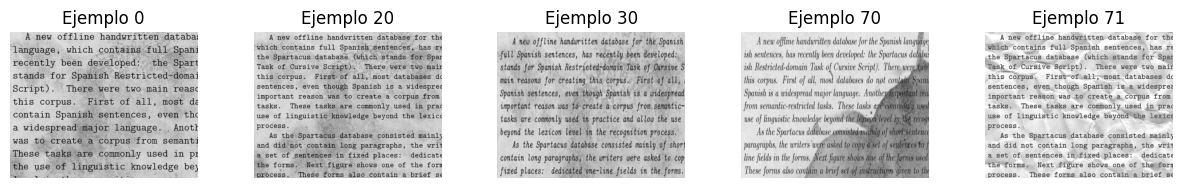

In [ ]:
example_idx = [0, 20, 30, 70, 71]
filtered_images = [X_test[img_idx]/255 for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

#### Modelo autoencoder y entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
class ConvAutoEncoder(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Dropout(0.5)
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - loss: 0.0691 - mse: 0.1983 - val_loss: 0.0549 - val_mse: 0.1555
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 662ms/step - loss: 0.0479 - mse: 0.1365 - val_loss: 0.0360 - val_mse: 0.0936
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - loss: 0.0312 - mse: 0.0797 - val_loss: 0.0309 - val_mse: 0.0698
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - loss: 0.0282 - mse: 0.0644 - val_loss: 0.0317 - val_mse: 0.0704
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - loss: 0.0285 - mse: 0.0645 - val_loss: 0.0307 - val_mse: 0.0683
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step - loss: 0.0275 - mse: 0.0627 - val_loss: 0.0296 - val_mse: 0.0682
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step - loss: 0.0268 - mse: 0.0633 - val_loss: 0.0288 - val_mse: 0.0658
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 709ms/step - loss: 0.0260 - mse: 0.0602 - val_loss: 0.0278 - val_mse: 0.0625
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - loss: 0.0250 - mse

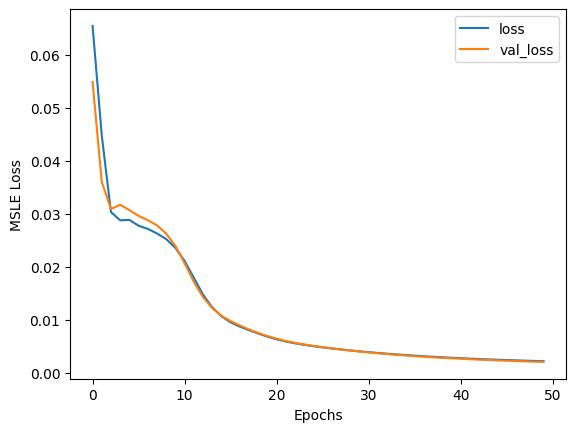

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

image_size=(420, 540)
model = ConvAutoEncoder(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

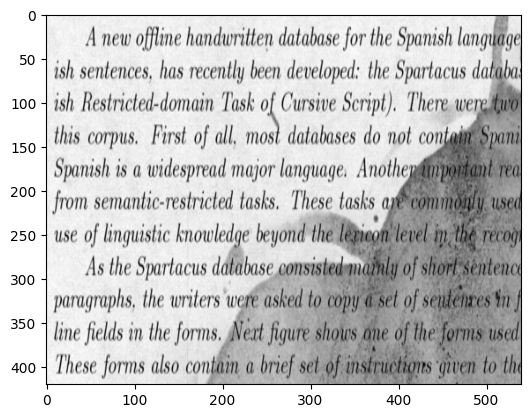

In [ ]:
plt.imshow(X_test[0, :, :, :], cmap = 'gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


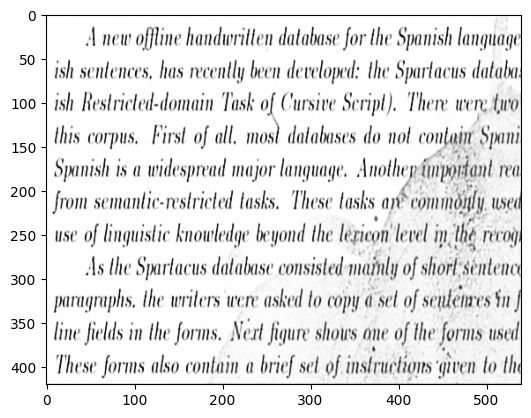

In [ ]:
y_pred_ae = model.predict(X_test[0:5, :, :, :])
plt.imshow(y_pred_ae[0, :, :, :], cmap='gray')

### LSTM

### Análisis producción de leche entre los años 1962 y 1975

In [4]:
df_leche = pd.read_csv('monthly_milk_production.csv')

In [5]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [6]:
df_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [7]:
df_leche.shape

(168, 2)

In [8]:
df_leche.isnull().sum()

,0
Date,0
Production,0


In [9]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


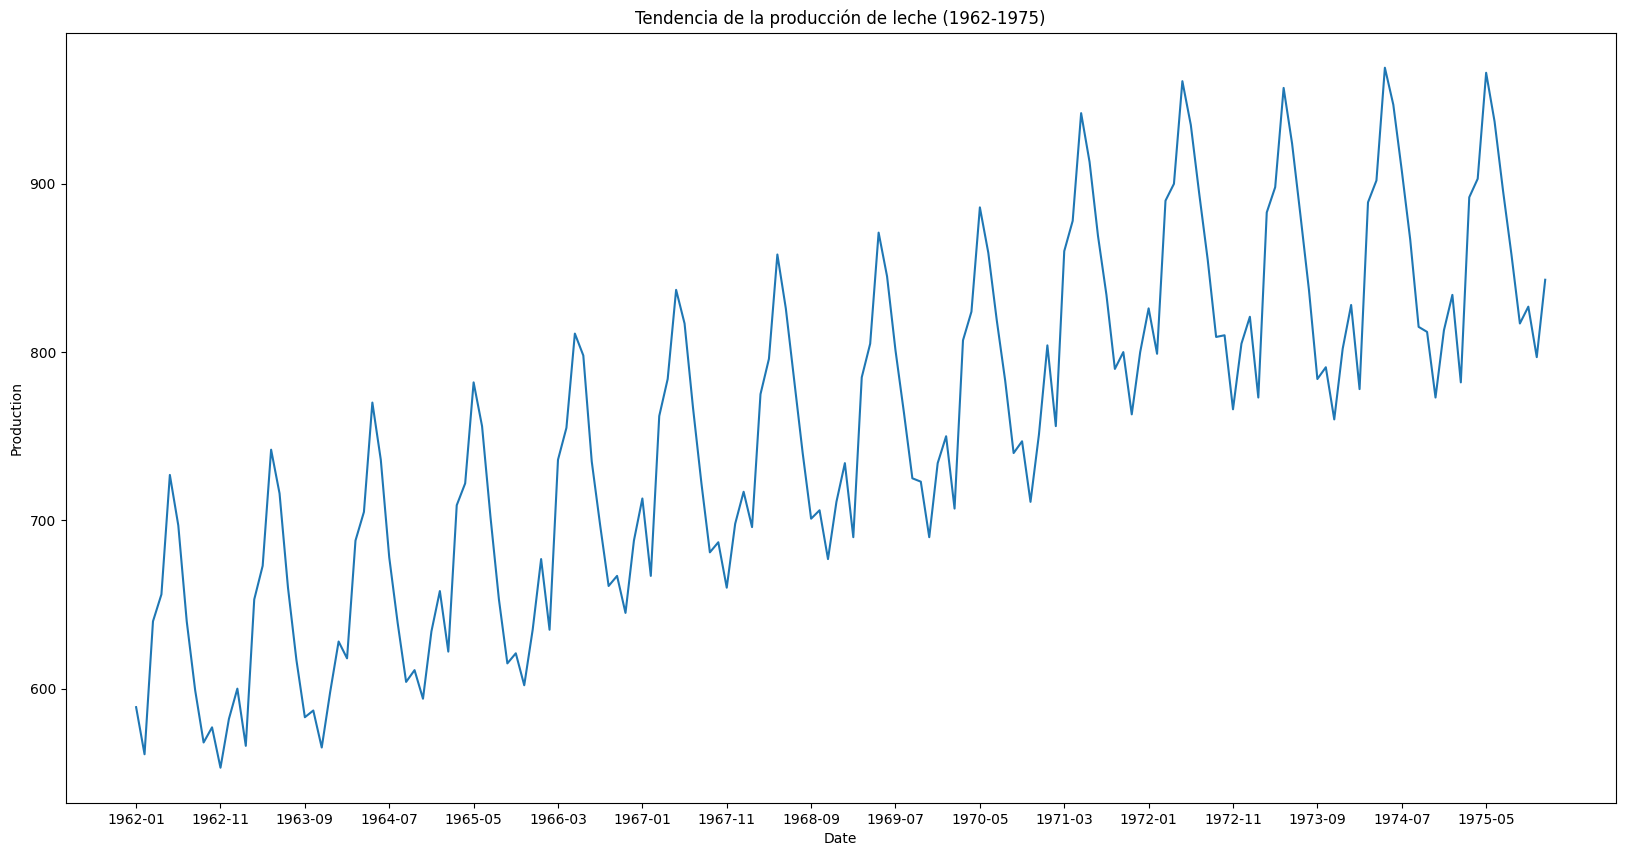

In [10]:
# Análisis temporal: Cambios de "Production" a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=df_leche, x='Date', y='Production')
plt.title('Tendencia de la producción de leche (1962-1975)')
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

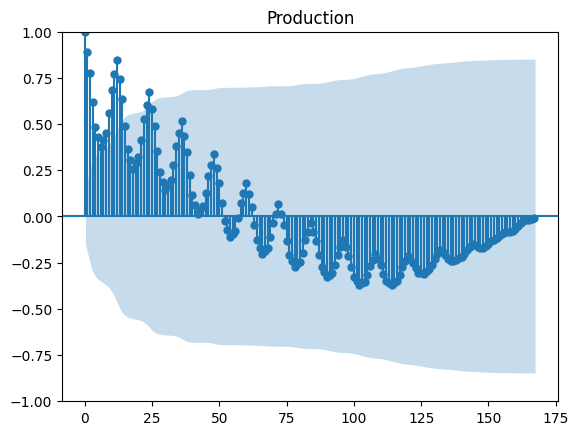

In [ ]:
# Autocorrelation
plot_acf(df_leche['Production'], lags=167, title='Production', alpha = 0.05)
plt.show()

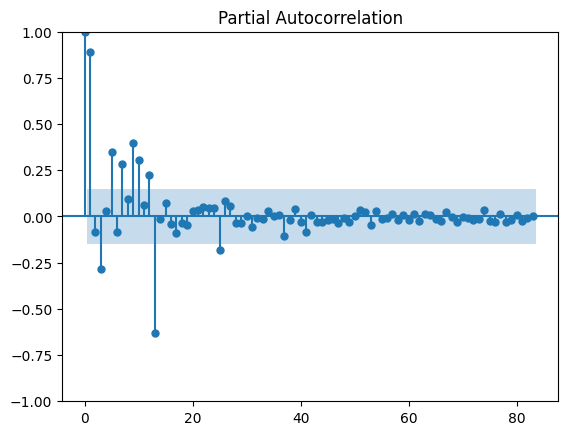

In [ ]:
# Partial Autocorrelation
plot_pacf(df_leche['Production'], lags=83)
plt.show()

**Estacionariedad:**

Corresponde a una propiedad clave en el análisis de series temporales. Una serie temporal se considera `estacionaria`si sus propiedades estadísticas, como la media y la varianza, son constantes en el tiempo. En términos prácticos, una serie estacionaria no tiene tendencia ni estacionalidad, y cualquier cambios observado en la serie es puramente ruido aleatorio.

Para verificar si una serie temporal es estacionaria o no, una de las pruebas más utilizadas es la Prueba de **Dickey-Fuller Aumentada (ADF)**.

Esta prueba tiene las siguientes hipótesis:

**Hipótesis nula (H₀):** La serie tiene una raíz unitaria (es decir, la serie no es estacionaria).

**Hipótesis alternativa (H₁):** La serie es estacionaria.

Si el valor `p` de la prueba es menor a un nivel de significancia, como `0.05`, se rechaza la hipótesis nula y podemos concluir que la serie es estacionaria.

In [ ]:
adf_result = sts.adfuller(df_leche['Production'])

# Extraer los resultados claves
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar los resultados de la prueba ADF
adf_statistic, p_value, critical_values

(-1.3038115874221308,
 0.6274267086030311,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677})

Los resultados de la prueba de **Dickey-Fuller Aumentada (ADF)** para la variable **Production** son los siguientes:

- **Estadístico ADF:** resultado -1.30, cuanto más negativo sea este valor más probable es que la serie sea estacionaria. Si el estadístico ADF es menor (más negativo) que los valores críticos, se puede rechazar la hipótesis nula y concluir que la serie es estacionaria. En este caso, el valor de -1.30 no es lo suficientemente negativo para superar los valores críticos, lo que sugiere que la serie no es estacionaria.

- **Valor p:** resultado 0.63, esto significa que al ser mayor que el nivel de significancia comúnmente utilizado (0.05, o 5%), no se podría rechazar la hipótesis nula donde se establece que la serie tiene una raíz unitaria. Esto quiere decir, que la prueba sugiere que la serie `no es estacionaria`.

- **Valores críticos:**

    1% -> -3.47 El 1% respresenta un valor crítico muy conservador, lo cual quiere decir que si el estadístico ADF es menor que este valor, hay evidencia muy fuerte que la serie es estacionaria.

    5% -> -2.88 El 5% es un valor conmúnmente utilizado. Si el estadístico ADF es menor que este valor, podemos concluir que la serie es estacionaria.

    10% -> -2.58 El 10% es el valor máximo. En este caso, si el estadístico ADF es menor que este valor, la serie es estacionaria, pero menos convincente.


**En conclusión, gracias a los valores obtenidos mediante la prueba ADF, podemos indicar que la variable Production no presenta estacionariedad**

Puntos de quiebre detectados: [50, 110, 168]


<Figure size 1000x600 with 0 Axes>

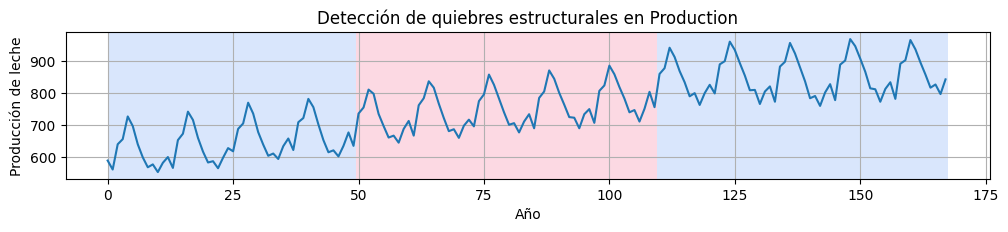

In [ ]:
# Convertir los datos a formato de numpy para aplicar la detección de quiebres
signal = df_leche['Production'].values

# Crear un modelo para detectar quiebres (usando el método de cambios de media)
algo = rpt.Pelt(model="rbf").fit(signal)

# Definir un valor para penalización (esto determina la sensibilidad para detectar quiebres)
pen = 10

# Identificar quiebres
breakpoints = algo.predict(pen=pen)

# Mostrar los puntos donde se detectaron quiebres
print("Puntos de quiebre detectados:", breakpoints)

# Visualizar los quiebres detectados
plt.figure(figsize=(10, 6))
rpt.display(signal, breakpoints)
plt.title('Detección de quiebres estructurales en Production')
plt.xlabel('Año')
plt.ylabel('Producción de leche')
plt.grid(True)
plt.show()

In [11]:
df_leche["Date"] = df_leche['Date'].str.replace('-', '')

In [12]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(split_percent=0.8):
    df = df_leche
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
#def get_XY(dat, time_steps):
#    Y_ind = np.arange(time_steps, len(dat), time_steps)
#    Y = dat[Y_ind]
#    rows_x = len(Y)
#    X = dat[range(time_steps*rows_x)]
#    X = np.reshape(X, (rows_x, time_steps, 1))
#    return X, Y

def get_XY(data, input_steps, forecast_steps):

    X, Y = [], []
    for i in range(len(data) - input_steps - forecast_steps + 1):
        X.append(data[i:i+input_steps]) # input_steps hacia el pasado
        Y.append(data[i+input_steps+forecast_steps-1])  # Valor 3 meses adelante
    X = np.array(X).reshape(-1, input_steps, 1)
    Y = np.array(Y)
    return X, Y

def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Production')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


Epoch 1/100
64/64 - 7s - 116ms/step - loss: 0.0448 - val_loss: 0.0631
Epoch 2/100
64/64 - 1s - 9ms/step - loss: 0.0217 - val_loss: 0.1040
Epoch 3/100
64/64 - 0s - 7ms/step - loss: 0.0220 - val_loss: 0.1019
Epoch 4/100
64/64 - 1s - 10ms/step - loss: 0.0209 - val_loss: 0.0893
Epoch 5/100
64/64 - 1s - 9ms/step - loss: 0.0197 - val_loss: 0.0848
Epoch 6/100
64/64 - 1s - 8ms/step - loss: 0.0186 - val_loss: 0.0806
Epoch 7/100
64/64 - 1s - 9ms/step - loss: 0.0177 - val_loss: 0.0829
Epoch 8/100
64/64 - 1s - 10ms/step - loss: 0.0170 - val_loss: 0.0845
Epoch 9/100
64/64 - 1s - 8ms/step - loss: 0.0164 - val_loss: 0.0849
Epoch 10/100
64/64 - 1s - 9ms/step - loss: 0.0161 - val_loss: 0.0882
Epoch 11/100
64/64 - 1s - 9ms/step - loss: 0.0158 - val_loss: 0.0791
Epoch 12/100
64/64 - 1s - 10ms/step - loss: 0.0154 - val_loss: 0.0940
Epoch 13/100
64/64 - 1s - 10ms/step - loss: 0.0157 - val_loss: 0.0704
Epoch 14/100
64/64 - 0s - 7ms/step - loss: 0.0145 - val_loss: 0.0826
Epoch 15/100
64/64 - 0s - 8ms/step - 

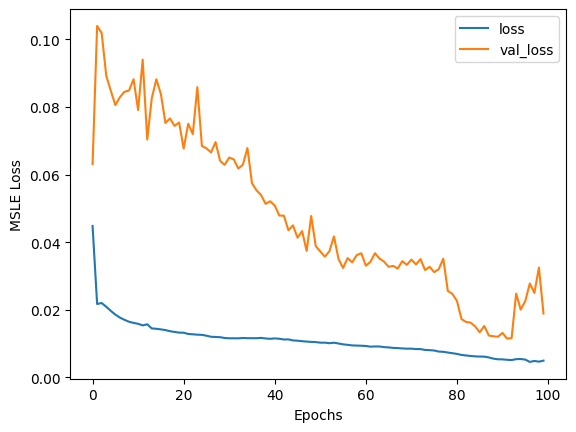

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Train RMSE: 0.072 RMSE
Test RMSE: 0.137 RMSE


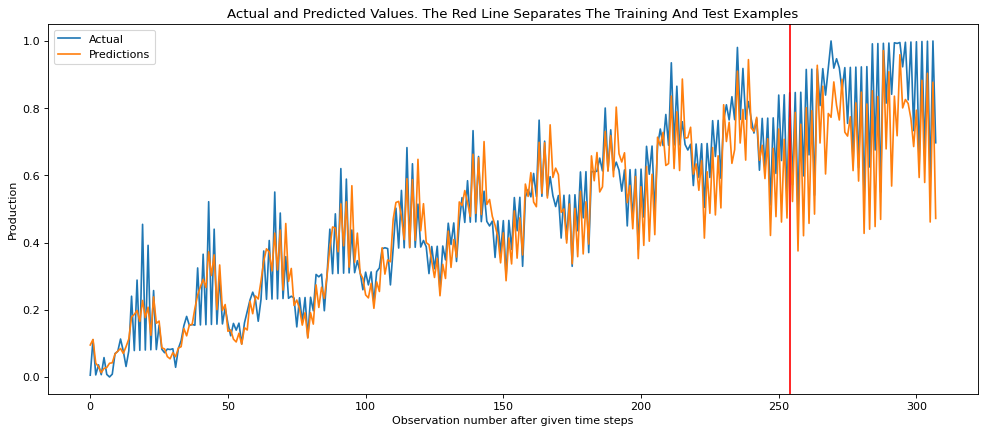

In [18]:
time_steps = 12
forecast_steps = 3
train_data, test_data, data = get_train_test()
trainX, trainY = get_XY(train_data, time_steps, forecast_steps)
testX, testY = get_XY(test_data, time_steps, forecast_steps)

# Create model and train
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=100, batch_size=4, verbose=2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

## Análisis de resultados

## Conclusiones